In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("style.mplstyle")

In [2]:
def read_results():
    df = pd.read_parquet("results.parquet")
    df["normalized_return"] = df["return"] / df.holding_period
    return df

df = read_results()
df

,factor,holding_period,cut_off,realized_return_date,side,return,normalized_return
0,factor_1,1,0.05,2016-03-02,long,0.012724,0.012724
1,factor_1,1,0.05,2016-03-02,short,-0.014056,-0.014056
2,factor_1,1,0.05,2016-03-03,long,0.006367,0.006367
3,factor_1,1,0.05,2016-03-03,short,-0.015051,-0.015051
4,factor_1,1,0.05,2016-03-04,long,0.004394,0.004394
...,...,...,...,...,...,...,...
384955,factor_3,80,0.20,2022-01-10,short,-0.045816,-0.000573
384956,factor_3,80,0.20,2022-01-11,long,0.092658,0.001158
384957,factor_3,80,0.20,2022-01-11,short,-0.078080,-0.000976
384958,factor_3,80,0.20,2022-01-12,long,0.088462,0.001106


In [3]:
df.groupby(["factor", "holding_period", "cut_off", "side"]).normalized_return.sum()


factor    holding_period  cut_off  side 
factor_1  1               0.05     long    -0.058823
                                   short   -0.553539
                          0.10     long     0.017276
                                   short   -0.469923
                          0.15     long     0.113814
                                              ...   
factor_3  80              0.10     short   -0.865774
                          0.15     long     0.888992
                                   short   -0.899561
                          0.20     long     0.849959
                                   short   -0.887037
Name: normalized_return, Length: 264, dtype: float64

In [4]:
def plot_holding_period_returns(df: pd.DataFrame, period: int, side: str = "long"):
    wide_version = (
        df.loc[df.holding_period.eq(period) & df.side.eq(side)]
        .pivot_table(
            index="realized_return_date",
            values="normalized_return",
            columns=["factor", "cut_off"],
        )
        .cumsum()
        .unstack()
        .rename("cum_return")
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(15, 7))
    sns.lineplot(
        ax=ax,
        data=wide_version,
        x="realized_return_date",
        y="cum_return",
        hue="cut_off",
        style="factor",
    )
    ax.set_xlabel("Return Date")
    ax.set_ylabel("Return")
    ax.set_title(f"{side} {period} Day Holding Period")
    fig.savefig(f"plots/{side}_{period:02}_day_holding_period.png")


In [5]:
holding_periods = df.holding_period.unique()
for p in holding_periods:
    for side in ["long", "short"]:
        # plot_holding_period_returns(df, p, side=side)
        pass


In [6]:
def single_holding_period_side_CV(df: pd.DataFrame, period: int, side: str):
    wide_version = (
        # Filter to the period and side requested
        df.loc[df.holding_period.eq(period) & df.side.eq(side)]
        # Convert to a pivot table where rows are the dates, the columns are factor and
        # cut_off, and the values are the return
        .pivot_table(
            index="realized_return_date",
            columns=["factor", "cut_off"],
            values="normalized_return",
        )
        # Calculate the cumulative sum of the returns for each column
        .cumsum()
        # Get the last row (the total cumulative return)
        .iloc[-1, :]
        # Give it a useful name
        .rename("cum_return")
        # Pop the index back into regular columns. Columns are now:
        # - factor
        # - cut_off
        # - cum_return
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(ax=ax, data=wide_version, x="cut_off", y="cum_return", hue="factor")
    ax.set_xlabel("Cut Off")
    ax.set_ylabel("Cumulative Return")
    ax.set_title(f"Normalized {period} Day {side} Returns")
    


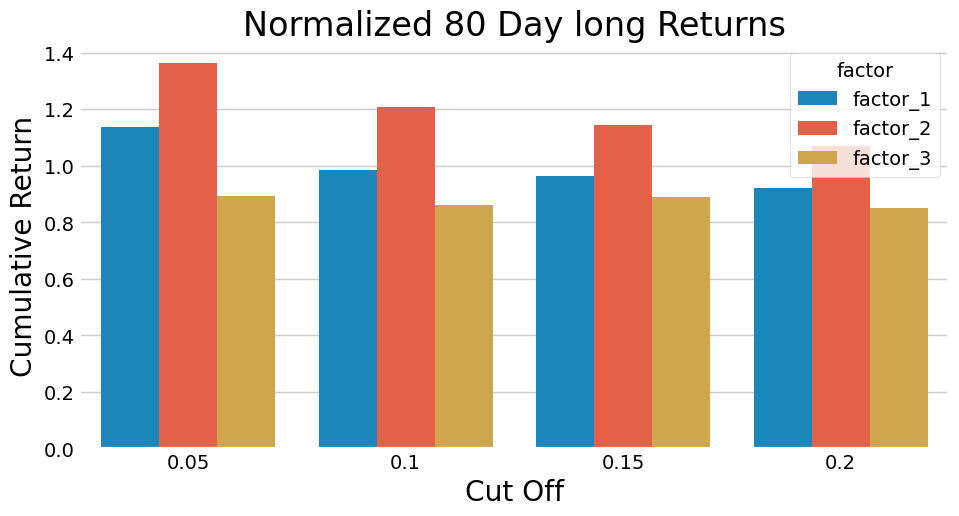

In [7]:
single_holding_period_side_CV(df, period=80, side="long")

In [8]:
chunked = (
    # For each of the hyper-parameters
    df.groupby(["holding_period", "cut_off", "side", "factor"])
    # Resample it to a 300 day period, using realized_return_date as the date column
    .resample("300D", on="realized_return_date")
    # Calculate the sum for each 300 day chunk
    .sum(numeric_only=True)
    # Select just the normalized returns
    # Pop the other columns from the index back to regular columns
    # Ends up with columns:
    # - holding_period
    # - cut_off
    # - side
    # - factor
    # - realized_return_date
    # - normalized_return
    .normalized_return.reset_index()
)
chunked


,holding_period,cut_off,side,factor,realized_return_date,normalized_return
0,1,0.05,long,factor_1,2016-03-02,0.098036
1,1,0.05,long,factor_1,2016-12-27,0.046565
2,1,0.05,long,factor_1,2017-10-23,-0.003336
3,1,0.05,long,factor_1,2018-08-19,0.047911
4,1,0.05,long,factor_1,2019-06-15,-0.179253
...,...,...,...,...,...,...
2035,80,0.20,short,factor_3,2018-02-13,-0.052736
2036,80,0.20,short,factor_3,2018-12-10,-0.057312
2037,80,0.20,short,factor_3,2019-10-06,-0.027220
2038,80,0.20,short,factor_3,2020-08-01,-0.380572


In [9]:
# Now that we have the chunks, we want the median normalized return for each set of hyperparamters
median_normalized_return = (
    chunked.groupby(["holding_period", "cut_off", "side", "factor"])
    .normalized_return.median()
    .rename("median_normalized_return")
    .reset_index()
)
median_normalized_return


,holding_period,cut_off,side,factor,median_normalized_return
0,1,0.05,long,factor_1,0.024652
1,1,0.05,long,factor_2,-0.000202
2,1,0.05,long,factor_3,0.024241
3,1,0.05,short,factor_1,-0.073986
4,1,0.05,short,factor_2,-0.078375
...,...,...,...,...,...
259,80,0.20,long,factor_2,0.075717
260,80,0.20,long,factor_3,0.114923
261,80,0.20,short,factor_1,-0.109245
262,80,0.20,short,factor_2,-0.143042


In [10]:
long_strats = median_normalized_return.loc[median_normalized_return.side.eq("long")]

best_long_strat = long_strats.loc[long_strats.median_normalized_return.idxmax()]
best_long_strat

holding_period                    40
cut_off                         0.15
side                            long
factor                      factor_1
median_normalized_return    0.155177
Name: 204, dtype: object

In [11]:
short_strats = median_normalized_return.loc[median_normalized_return.side.eq("short")]

best_short_strat = short_strats.loc[short_strats.median_normalized_return.idxmax()]
best_short_strat

holding_period                     1
cut_off                          0.1
side                           short
factor                      factor_3
median_normalized_return   -0.015525
Name: 11, dtype: object

In [12]:
# Finally, we want to know the best strategy when using both the long and the short
mixed = (
    median_normalized_return.groupby(["holding_period", "cut_off", "factor"])
    .median_normalized_return.median()
    .reset_index()
)
best_mixed_strat = mixed.loc[mixed.median_normalized_return.idxmax()]
best_mixed_strat


holding_period                    60
cut_off                         0.05
factor                      factor_3
median_normalized_return    0.015284
Name: 110, dtype: object

In [13]:
(
    df.loc[df.holding_period.eq(60) & df.cut_off.eq(0.05) & df.factor.eq("factor_3")]
    .groupby("realized_return_date")
    .normalized_return.sum()
    .reset_index(drop=True)
)


0       0.001028
1       0.000667
2       0.000998
3       0.000727
4       0.001160
          ...   
1415    0.000756
1416    0.000556
1417    0.000805
1418   -0.000108
1419    0.000071
Name: normalized_return, Length: 1420, dtype: float64

In [14]:
final_strats = pd.DataFrame(
    dict(
        realized_return_date=df.realized_return_date.unique(),
        long=df.loc[
            df.holding_period.eq(40)
            & df.cut_off.eq(0.15)
            & df.side.eq("long")
            & df.factor.eq("factor_1")
        ].normalized_return.reset_index(drop=True),
        short=df.loc[
            df.holding_period.eq(1)
            & df.cut_off.eq(0.1)
            & df.side.eq("short")
            & df.factor.eq("factor_3")
        ].normalized_return.reset_index(drop=True),
        mixed=df.loc[
            df.holding_period.eq(60) & df.cut_off.eq(0.05) & df.factor.eq("factor_3")
        ]
        .groupby("realized_return_date")
        .normalized_return.sum()
        .reset_index(drop=True),
    ),
).set_index("realized_return_date").cumsum()
final_strats


,long,short,mixed
realized_return_date,,,
2016-03-02,0.002723,-0.008895,0.001028
2016-03-03,0.004901,-0.014876,0.001695
2016-03-04,0.006604,-0.019363,0.002694
2016-03-07,0.008680,-0.026963,0.003420
2016-03-08,0.010458,-0.022127,0.004580
...,...,...,...
2022-01-06,NaN,-0.413888,NaN
2022-01-07,NaN,-0.410783,NaN
2022-01-10,NaN,-0.410363,NaN


In [15]:
spy = (
    pd.read_csv(
        "spy_returns.csv",
        usecols=["Date", "Cumsum"],
        parse_dates={"realized_return_date": ["Date"]},
    )
    .rename(columns={"Cumsum": "S&P500"})
    .set_index("realized_return_date")
)
spy


,S&P500
realized_return_date,
2016-03-02,0.006372
2016-03-03,0.011352
2016-03-04,0.013452
2016-03-07,0.019723
2016-03-08,0.015107
...,...
2022-11-28,0.296320
2022-11-29,0.294249
2022-11-30,0.325072


In [16]:
final_strats = pd.concat([final_strats, spy], join="inner", axis="columns")

Text(0.5, 1.0, 'Best Strategies')

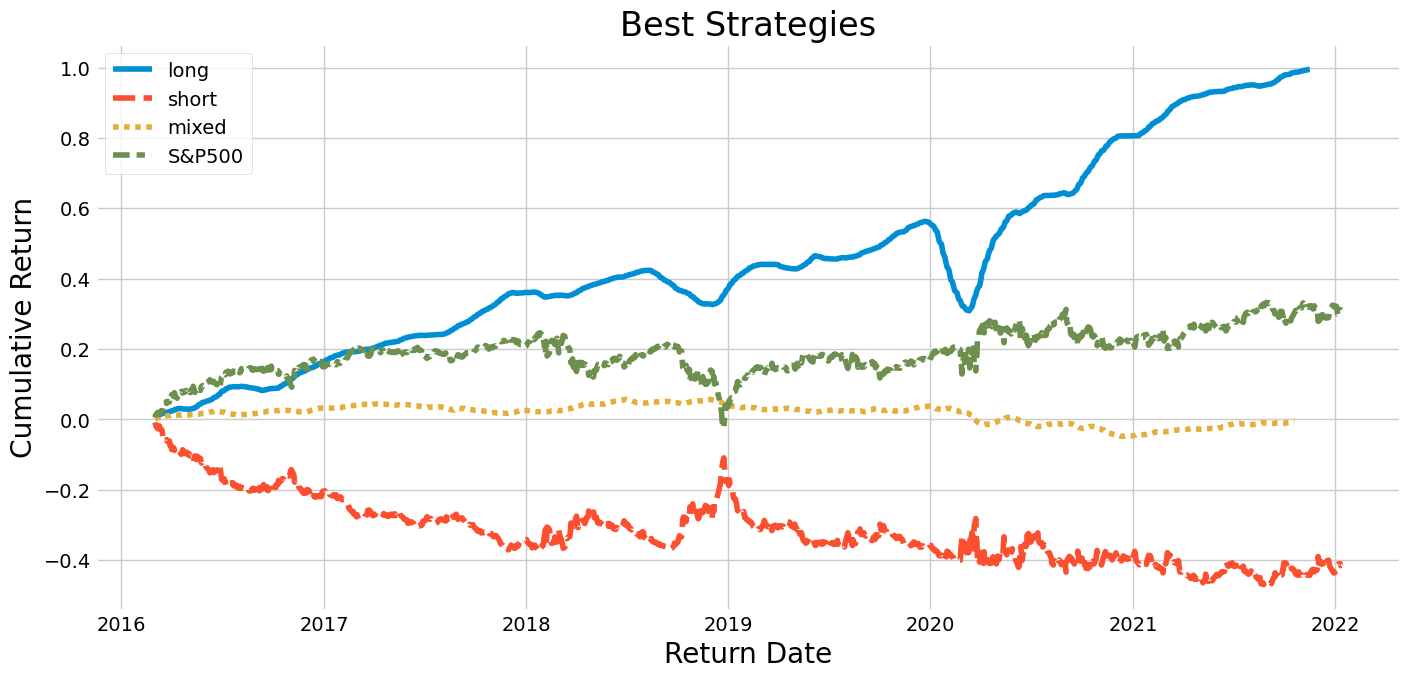

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(ax=ax, data=final_strats)
ax.set_xlabel("Return Date")
ax.set_ylabel("Cumulative Return")
ax.set_title("Best Strategies")